In [2]:
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
import os
os.environ['VXM_BACKEND'] = 'pytorch'
from voxelmorph import networks
import voxelmorph as vxm
from tqdm.notebook import trange
from tqdm.notebook import tqdm
import nibabel as nib

In [4]:
loss=np.load('loss_his.npy')

In [7]:
loss.shape

(100, 4)

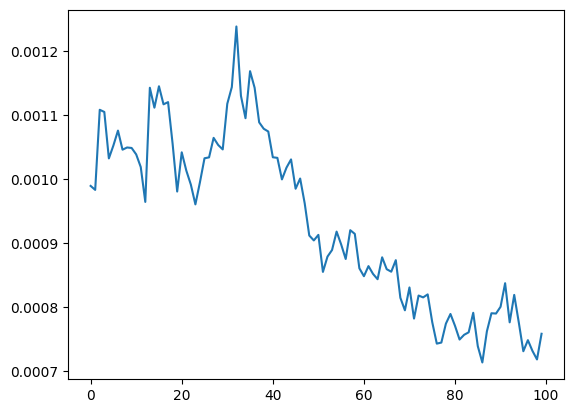

In [10]:
plt.plot(loss.mean(1))

In [4]:
import pathlib
path = pathlib.Path('../OASIS')
subj_lst_m = [str(f/'aligned_norm.nii.gz') for f in path.iterdir() if str(f).endswith('MR1')]

In [5]:
# prepare data
vols = [nib.load(f).get_fdata() for f in tqdm(subj_lst_m)]
x_vols = np.stack(vols, 0)
vol_shape = (160, 192, 224)
device = torch.device(2)

  0%|          | 0/414 [00:00<?, ?it/s]

In [16]:
from torch.utils.data import Dataset

class MRIDataset(Dataset):
    def __init__(self, img_data, transform=None, ):
        self.img_data = img_data.astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
        image = self.img_data[idx, np.newaxis, ...]
        if self.transform:
            image = self.transform(image)
        return image

In [17]:
dataset = MRIDataset(x_vols,)

In [18]:
from torch.utils.data import DataLoader
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    torch.random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(10086)
train_dataloader = DataLoader(dataset,batch_size=1,sampler=torch.utils.data.RandomSampler(dataset),generator=g,worker_init_fn=seed_worker)

In [9]:
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]

In [10]:
atlas = torch.mean((torch.from_numpy(dataset.img_data[:10])),dim=0).squeeze().unsqueeze(0)

In [11]:
model = torch.compile(networks.TemplateCreation(vol_shape,atlas,nb_unet_features=[enc_nf, dec_nf])).to(device)

In [12]:
image_loss_func = nn.MSELoss()
neg_loss_func = lambda _,y_pred: image_loss_func(y_pred, torch.stack([model.atlas for _ in range(y_pred.shape[0])]))
mean_flow_loss = lambda _,y_pred: torch.square(y_pred).mean()
losses = [image_loss_func, neg_loss_func, mean_flow_loss, vxm.losses.Grad('l2', loss_mult=2).loss]
loss_weights = [0.5, 0.5, 0.1, 0.01]

In [13]:
optimizer=torch.optim.Adam(model.parameters(), lr=1e-4,eps=1e-07)

In [14]:
loss_his = []
step = 100

In [19]:
for _ in trange(1500):
    loss_epoch = 0

    for batch, (train_features) in enumerate(train_dataloader):
        optimizer.zero_grad()
        train_features = train_features.to(device)
        batch_size = train_features.shape[0]
        output = model(train_features)
        output_p = [train_features,None,None,None]

        loss = torch.stack([losses[i](output_p[i],output[i])*loss_weights[i] for i in range(4)])

        loss.sum().backward()
        optimizer.step()
        loss_epoch+=loss
        if (batch+1)%step == 0:
            break
    loss_his.append([loss_epoch[i].item()/(batch+1) for i in range(4)])

  0%|          | 0/1500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
atlas = model.atlas.cpu().detach()

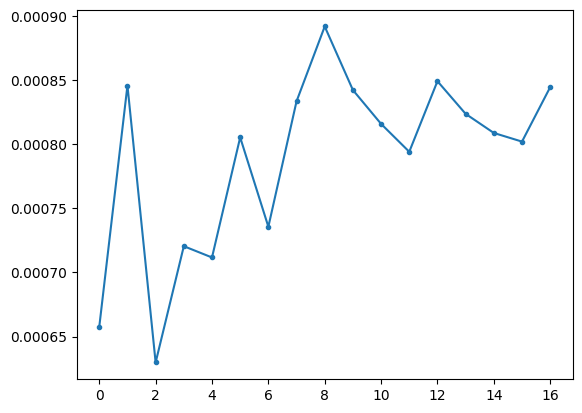

In [20]:
ls=plt.plot(np.array(loss_his).mean(1),'.-')

In [22]:
atlas.shape

torch.Size([1, 160, 192, 224])

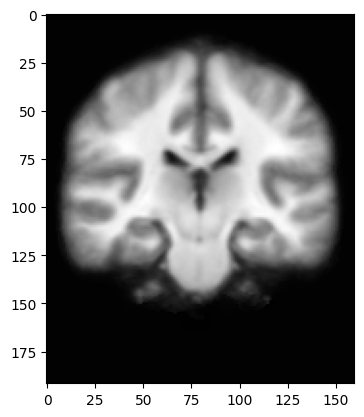

In [25]:
plt.imshow(atlas[0,...,100].T,cmap='gray')